<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/Fallstudie1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie

##PIP, OR-Tools und Pandas

In [1]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools

In [2]:
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

In [3]:
! git clone https://github.com/AlexKressner/Industrielles_Management

fatal: destination path 'Industrielles_Management' already exists and is not an empty directory.


In [4]:
path = "Industrielles_Management/Daten/Fallstudie/"

##Ziel:
Maximierung der bedienten Nachfrage innerhalb der vorgegebenen Lieferzeit und des Budgets.


##Daten:


In [5]:
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [6]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten q als (i, j) Tupel
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Kontinuierliche Variable, die den %ualen Anteil der Nachfrage eines Quadranten $ q (i,j) $ repräsentiert, der von  Darkstore $ s $ bedient wird.


In [7]:
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [8]:
D = {q: nachfrage_df.iat[q[1],q[0]] for q in Q} # Nachfrage im Quadranten q als Bestellungen pro Tag


In [9]:
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.BoolVar(f'y[{q},{s}]')

In [10]:
z = {}
for s in S:
    for q in Q:
        z[q, s] = solver.IntVar(0, solver.infinity(), f'z[{q},{s}]')

###Dictionaries:
- Lagerumschlagsleistung je potentiellem Standort $ s $
- Errichtungskosten je potentiellem Standort $ s $
- Koordinaten je potentiellem Standort $ s $

In [11]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores.

$ T $: Maximale Lieferzeit $10 Minuten$.

$ A $: Maximale Anzahl von Quadranten, die ein Fahrradkurier bedienen kann $5 Quadranten$.


In [12]:
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget für die Einrichtung von Dark Stores
G = 25  # Geschwindigkeit in KM/H
T = 10  # Maximale Lieferzeit 10 Minuten
TF1= 3  # Zeitfresser in Minuten Warenbereitstellung AE
TF2= 1  # Zeitfresser in Minuten Warenübergabe beim Kunden
TV= (T-TF1-TF2) # Verbleibende Zeit abzüglich Zeitfressern
A = round((TV/2)/0.25*G/60, None) # max Reichweite in Quadranten für eine Richtung

###Restriktionen:

####Nachfragerestriktion:
$\sum_{s \in S} y_{qs} \leq 2 \quad \forall q \in Q $

Jeder Quadrant wird von höchstens zwei Dark Stores bedient.

In [13]:
# Nachfragerestriktionen
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 2)

 #### Zuordnungsrestriktion:
$y_{qs} \leq x_s \quad \forall q \in Q, \forall s \in S$

 Ein Darkstore kann nur einen Quadranten bedienen, wenn er errichtet wurde.

In [14]:
# Zuordnungsrestriktionen
for s in S:
    for q in Q:
        solver.Add(z[q, s] <= D[q] * y[q, s])

####Budgetrestriktion:
$\sum_{s \in S} x_s \cdot C_s \leq B $

Ein Dark Store kann nur eingerichtet werden, wenn das Budget dies zulässt.


In [15]:
# Budgetrestriktion
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7de390969350> >

####Lagerumschlagleistungsrestriktion:
$\sum_{q \in Q} y_{qs} \cdot D_{q} \leq x_s \cdot L_s \quad \forall s \in S $

Die Nachfrage eines Quadranten kann nur bedient werden, wenn die Lagerumschlagleistung ausreicht und ein Dark Store vorhanden ist.


In [16]:
# Lagerumschlagleistungsrestriktionen
for s in S:
    solver.Add(solver.Sum([z[q, s] for q in Q]) <= x[s] * L[s])

####Reichweitenrestriktion für Fahrradkuriere:
$\text{Strecke}(s, q) > A \Rightarrow y_{qs} = 0 \quad \forall q \in Q, \forall s \in S $

Die Anzahl der von einem Fahrradkurier zurückgelegten Quadranten $Strecke$ darf nie größer $A$ sein, falls bestätigt, dass Quadrant $q$ von Standort $s$ beliefert wird.

In [17]:
# Reichweitenrestriktion für Fahrradkuriere
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > 5:
            solver.Add(y[q, s] == 0)

##Lösung:
###Zielfunktion:
Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{sq} y_{qs} \cdot D_q $

In [18]:
# Ändern Sie die Zielfunktion
solver.Maximize(solver.Sum([z[q, s] for q in Q for s in S]))
# Lösen des Modells
status = solver.Solve()

In [29]:
# Ausgabe
if status == pywraplp.Solver.OPTIMAL:
    gesamtnachfrage = sum(D.values())
    ausgelieferte_waren = sum(z[q, s].solution_value() for q in Q for s in S if z[q, s].solution_value() > 0)
    print(f'Prozentuale Erfüllung der Gesamtnachfrage: {round((ausgelieferte_waren/gesamtnachfrage*100), ndigits=2)}%')
    print('Lösung gefunden:')
    print('Zielfunktionswert (Kosten) =', solver.Objective().Value())
    # for s in S:
    #     if x[s].solution_value() == 1:
    #         print(f'Standort {s} wird eingerichtet.')
    #         vollstaendig = [q for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() == D[q]]
    #         if vollstaendig:
    #             print(f'Vollständige Lieferungen von Standort {s} mit {", ".join(str(q) for q in vollstaendig)} vollständig beliefert.')
    #         for q in Q:
    #             if z[q, s].solution_value() > 0 and z[q, s].solution_value() != D[q]:
    #                 print(f'T von Standort {s} liefert {[round(z[q, s].solution_value()/D[q]*100)]}% der Einheiten an Quadrant {q}.')
    for s in S:
      if x[s].solution_value() == 1:
          print(f'Standort {s} wird eingerichtet.')
          vollstaendig = [q for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() == D[q]]
          if vollstaendig:
              print(f'Vollständige Lieferungen von Standort {s} mit {", ".join(str(q) for q in vollstaendig)} vollständig beliefert.')
          teilweise = [(q, round(z[q, s].solution_value()/D[q]*100)) for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() != D[q]]
          if teilweise:
              print(f'Teilweise Lieferungen von Standort {s} mit {", ".join(f"{q[0]} ({q[1]}%)" for q in teilweise)} beliefert.')
else:
    print('Keine optimale Lösung gefunden.')

Prozentuale Erfüllung der Gesamtnachfrage: 99.73%
Lösung gefunden:
Zielfunktionswert (Kosten) = 8575.000000000002
Standort 1 wird eingerichtet.
Vollständige Lieferungen von Standort 1 mit (5, 12), (6, 9), (6, 11), (6, 12), (7, 10), (8, 6), (9, 7), (9, 8), (10, 9), (11, 12), (12, 11), (12, 12) vollständig beliefert.
Teilweise Lieferungen von Standort 1 mit (4, 12) (49%), (7, 11) (22%) beliefert.
Standort 2 wird eingerichtet.
Vollständige Lieferungen von Standort 2 mit (8, 1), (9, 0), (9, 1), (9, 3), (10, 0), (10, 1), (10, 2), (10, 3), (12, 1) vollständig beliefert.
Teilweise Lieferungen von Standort 2 mit (7, 3) (19%) beliefert.
Standort 3 wird eingerichtet.
Vollständige Lieferungen von Standort 3 mit (6, 9), (6, 11), (7, 9), (7, 10), (8, 11), (8, 12), (10, 9), (10, 11), (11, 7), (11, 8), (11, 9), (11, 10), (11, 12), (12, 7), (12, 11), (12, 12) vollständig beliefert.
Teilweise Lieferungen von Standort 3 mit (7, 12) (8%), (8, 10) (22%), (11, 11) (80%) beliefert.
Standort 4 wird eingerich

### Darstellung als Matrix, DF oder MatPlot

In [30]:
import numpy as np
import pandas as pd

# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Füllen Sie die Matrix mit den Ergebnissen Ihres Modells
for s in S:
    if x[s].solution_value() > 0:  # Wenn ein Darkstore an diesem Standort errichtet wurde
        for q in Q:
            if y[q, s].solution_value() == 1:  # Wenn der Standort s den Quadranten q beliefert
                if z[q, s].solution_value() == D[q]:  ergebnis_matrix[q[0], q[1]] = str(s) # Wenn die gelieferte Menge gleich der Nachfrage ist
                else:
                  if ergebnis_matrix[q[0], q[1]] is not None: ergebnis_matrix[q[0], q[1]] += '' + str(s)



# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:  # Wenn ein Darkstore an diesem Standort errichtet wurde
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

# Konvertieren Sie die Matrix in einen DataFrame für eine schönere Darstellung
ergebnis_df = pd.DataFrame(ergebnis_matrix).transpose()
ergebnis_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,None,None,None,9,None,None,None,None,None,2,2,None,None,None
1,None,None,None,9,9,None,None,None,2,2,2,None,2,None
2,None,None,9,9,9,9,None,9,None,None,2,None,4,None
3,None,None,9,9,9,79,9,9,None,2,2,4,None,None
4,None,9,9,9,S9,7,7,9,9,9,S2,None,4,None
5,9,9,7,7,9,9,9,9,7,4,4,4,4,None
6,7,9,9,7,S7,9,7,9,7,47,None,4,4,S4
7,7,7,9,7,9,9,9,7,7,1,None,3,4,None
8,None,7,7,9,S5,7,7,7,None,1,None,4,4,None
9,None,5,7,7,7,7,3,3,None,None,3,4,4,None


####Visualisierung

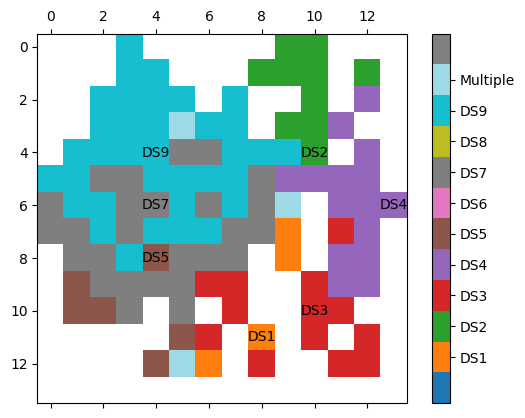

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_df.copy()
for i in range(14):
    for j in range(14):
        if num_matrix.iloc[i, j] is not None and isinstance(num_matrix.iloc[i, j], str):
            if "S" in num_matrix.iloc[i, j]:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j].replace("S", ""))
            else:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j])
# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix = num_matrix.fillna(-1)
# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan
# Ersetzen Sie alle int Werte über 10 durch -2
num_matrix[num_matrix > 10] = 10
# Create a new color map with an extra color for the '10' value
cmap = plt.get_cmap('tab20', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 2))  # 'tab20' provides 20 distinct colors
# Set the color for 'None' and '10'
cmap.set_under('white')  # For 'None'
cmap.set_over('gray')  # For '10'
# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()
cax = ax.matshow(num_matrix, cmap=cmap, vmin=0)  # Setzen Sie vmin auf 0, um die untere Grenze der Farbkarte festzulegen
# Create the colorbar with custom boundaries
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)+1), boundaries=np.arange(-0.5, np.nanmax(num_matrix)+2.5))  # +2.5 to include '10' and 'None'
# Set the labels
labels = ['DS'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix)))] + ['Multiple']  # Add labels for 'None' and '10'
cbar.ax.set_yticklabels(labels)
# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        j, i = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'DS{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()